# Kaggle: HomeCredit

Notebook based on: https://www.kaggle.com/code/uzdavinys/homecredit-population-stability-index

In [1]:
# !pip install seaborn

In [2]:
# suppress enjoying warnings from seaborn
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
import os

# for fiding file names
from pathlib import Path
from glob import glob
import gc

# data processing libraries
import polars as pl
import numpy as np
import pandas as pd
import polars.selectors as cs

# for visualizing data
import seaborn as sns
import matplotlib.pyplot as plt

# sklearn functions
from sklearn.model_selection import train_test_split, StratifiedGroupKFold
from sklearn.preprocessing import LabelEncoder
# for validating models
from sklearn.metrics import roc_auc_score, roc_curve

# LightGBM modeling
import lightgbm as lgb

# define default colors for plots in notebook
from matplotlib import cycler
from matplotlib.colors import LinearSegmentedColormap
COLORS = ["#068D9D", "#53599A", "#607BB0", "#6D9DC5", "#77BECF", "#80DED9", "#AEECEF"]
plt.rc('axes', facecolor='#E6E6E6', edgecolor='none', axisbelow=True, grid=True, prop_cycle=cycler('color', COLORS))

In [3]:
# project CONSTANTS
# ROOT = Path("/kaggle/input/home-credit-credit-risk-model-stability")
DRIVE = "I:"
USERNAME = os.environ['USERNAME']
ROOT = Path(DRIVE).joinpath(USERNAME, "data", "Home Credit - Credit Risk Model Stability")
TRAIN_DIR = ROOT / "parquet_files" / "train"
TEST_DIR = ROOT / "parquet_files" / "test"
SEED = 2024

In [4]:
TRAIN_DIR

WindowsPath('I:smouz/data/Home Credit - Credit Risk Model Stability/parquet_files/train')

In [5]:
# DRIVE= "I:"
# USERNAME = os.environ['USERNAME']

# DATA_DIR = Path(DRIVE).joinpath(USERNAME, "data", "Home Credit - Credit Risk Model Stability")
# DATA_FILES_DIR = DATA_DIR.joinpath("parquet_files")
# DATA_FILES_DIR

# filename = DATA_FILES_DIR.joinpath("train", "train_base.parquet")
# train_basetable = pl.read_parquet(filename)

# CREDIT_BUREAU_FILES = DATA_FILES_DIR.joinpath("train").glob("*credit_bureau_*parquet")
# PERSON_FILES = DATA_FILES_DIR.joinpath("train").glob("*person_*parquet")
# STATIC_FILES = DATA_FILES_DIR.joinpath("train").glob("*static_0_*parquet")
# STATIC_CB_FILES = DATA_FILES_DIR.joinpath("train").glob("*static_cb_*parquet")
# APPLPREV_FILES = DATA_FILES_DIR.joinpath("train").glob("*applprev_*parquet")
# DEBIT_FILES = DATA_FILES_DIR.joinpath("train").glob("*debitcard_*parquet")
# DEPOSIT_FILES = DATA_FILES_DIR.joinpath("train").glob("*deposit_*parquet")
# TAX_REG_FILES = DATA_FILES_DIR.joinpath("train").glob("*tax_registry_*parquet")
# OTHER_FILES = DATA_FILES_DIR.joinpath("train").glob("*other_*parquet")

# PERSON_FILES_LIST = list(PERSON_FILES)
# CREDIT_BUREAU_FILES_LIST = list(CREDIT_BUREAU_FILES)
# CREDIT_BUREAU_FILES_LIST[-3:]

In [6]:
class Pipeline:
    """
    Helper class taken from notebook:
    https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm
    """
    def set_table_dtypes(df):
        for col in df.columns:
            if col in ["case_id", "WEEK_NUM", "num_group1", "num_group2"]:
                df = df.with_columns(pl.col(col).cast(pl.Int64))
            elif col in ["date_decision"]:
                df = df.with_columns(pl.col(col).cast(pl.Date))
            elif col[-1] in ("P", "A"):
                df = df.with_columns(pl.col(col).cast(pl.Float64))
            elif col[-1] in ("M",):
                df = df.with_columns(pl.col(col).cast(pl.String))
            elif col[-1] in ("D",):
                df = df.with_columns(pl.col(col).cast(pl.Date))
        return df

    def handle_dates(df):
        for col in df.columns:
            if col[-1] in ("D",):
                df = df.with_columns(pl.col(col) - pl.col("date_decision"))  #!!?
                df = df.with_columns(pl.col(col).dt.total_days()) # t - t-1
        df = df.drop("date_decision", "MONTH")
        return df

    def filter_cols(df):
        for col in df.columns:
            if col not in ["target", "case_id", "WEEK_NUM"]:
                isnull = df[col].is_null().mean()
                if isnull > 0.7:
                    df = df.drop(col)
        
        for col in df.columns:
            if (col not in ["target", "case_id", "WEEK_NUM"]) & (df[col].dtype == pl.String):
                freq = df[col].n_unique()
                if (freq == 1) | (freq > 200):
                    df = df.drop(col)
        
        return df

class Aggregator:
    """
    Helper class taken from notebook:
    https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm
    """    
    def num_expr(df):
        cols = [col for col in df.columns if col[-1] in ("P", "A")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def date_expr(df):
        cols = [col for col in df.columns if col[-1] in ("D")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def str_expr(df):
        cols = [col for col in df.columns if col[-1] in ("M",)]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def other_expr(df):
        cols = [col for col in df.columns if col[-1] in ("T", "L")]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]
        return expr_max
    
    def count_expr(df):
        cols = [col for col in df.columns if "num_group" in col]
        expr_max = [pl.max(col).alias(f"max_{col}") for col in cols]  # max & replace col name
        return expr_max
    
    def get_exprs(df):
        exprs = Aggregator.num_expr(df) + \
                Aggregator.date_expr(df) + \
                Aggregator.str_expr(df) + \
                Aggregator.other_expr(df) + \
                Aggregator.count_expr(df)

        return exprs

def read_file(path, depth=None):
    """
    Helper function taken from notebook:
    https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm
    """
    df = pl.read_parquet(path)
    df = df.pipe(Pipeline.set_table_dtypes)
    if depth in [1,2]:
        df = df.group_by("case_id").agg(Aggregator.get_exprs(df)) 
    return df


def read_files(regex_path, depth=None):
    """
    Helper function taken from notebook:
    https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm
    """
    chunks = []
    
    for path in glob(str(regex_path)):
        df = pl.read_parquet(path)
        df = df.pipe(Pipeline.set_table_dtypes)
        if depth in [1, 2]:
            df = df.group_by("case_id").agg(Aggregator.get_exprs(df))
        chunks.append(df)
    
    df = pl.concat(chunks, how="vertical_relaxed")
    df = df.unique(subset=["case_id"])
    return df


def feature_eng(df_base, depth_0, depth_1, depth_2):
    """
    Helper function taken from notebook:
    https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm
    """
    df_base = (
        df_base
        .with_columns(
            month_decision = pl.col("date_decision").dt.month(),
            weekday_decision = pl.col("date_decision").dt.weekday(),
        )
    )
    for i, df in enumerate(depth_0 + depth_1 + depth_2):
        df_base = df_base.join(df, how="left", on="case_id", suffix=f"_{i}")
    df_base = df_base.pipe(Pipeline.handle_dates)
    return df_base



def to_pandas(df_data, cat_cols=None):
    """
    Helper function taken from notebook:
    https://www.kaggle.com/code/daviddirethucus/home-credit-risk-lightgbm
    """
    df_data = df_data.to_pandas()
    if cat_cols is None:
        cat_cols = list(df_data.select_dtypes("object").columns)
    df_data[cat_cols] = df_data[cat_cols].astype("category")
    return df_data, cat_cols


def reduce_mem_usage(df, df_name, verbose=True):
    """
    This function changes pandas numerical dtypes (reduces bit size if possible)
    to reduce memory usage
    
    :param df: pandas DataFrame
    :param df_name: str, name of DataFrame
    :param verbose: bool, if True prints out message of how much memory usage was reduced
        
    :return:  pandas DataFrame       
    """
    numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']
    start_mem = df.memory_usage().sum() / 1024**2
    for col in df.columns:
        col_type = df[col].dtypes
        if col_type in numerics:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int64)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float32)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float64)
                else:
                    df[col] = df[col].astype(np.float64)
    # calculate memory after reduction
    end_mem = df.memory_usage().sum() / 1024**2
    if verbose:
        # reduced memory usage in percent
        diff_pst = 100 * (start_mem - end_mem) / start_mem
        msg = f'{df_name} mem. usage decreased to {end_mem:5.2f} Mb ({diff_pst:.1f}% reduction)'
        print(msg)
    return df

## Laod DAta

In [7]:
data_train = {
    "df_base": read_file(TRAIN_DIR / "train_base.parquet"),
    "depth_0": [
        read_file(TRAIN_DIR / "train_static_cb_0.parquet"),
        read_files(TRAIN_DIR / "train_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TRAIN_DIR / "train_applprev_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_a_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_tax_registry_c_1.parquet", 1),
        read_files(TRAIN_DIR / "train_credit_bureau_a_1_*.parquet", 1),
        read_file(TRAIN_DIR / "train_credit_bureau_b_1.parquet", 1),
        read_file(TRAIN_DIR / "train_other_1.parquet", 1),
        read_file(TRAIN_DIR / "train_person_1.parquet", 1),
        read_file(TRAIN_DIR / "train_deposit_1.parquet", 1),
        read_file(TRAIN_DIR / "train_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TRAIN_DIR / "train_credit_bureau_b_2.parquet", 2),
        read_files(TRAIN_DIR / "train_credit_bureau_a_2_*.parquet", 2),
    ]
}

data_test = {
    "df_base": read_file(TEST_DIR / "test_base.parquet"),
    "depth_0": [
        read_file(TEST_DIR / "test_static_cb_0.parquet"),
        read_files(TEST_DIR / "test_static_0_*.parquet"),
    ],
    "depth_1": [
        read_files(TEST_DIR / "test_applprev_1_*.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_a_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_b_1.parquet", 1),
        read_file(TEST_DIR / "test_tax_registry_c_1.parquet", 1),
        read_files(TEST_DIR / "test_credit_bureau_a_1_*.parquet", 1),
        read_file(TEST_DIR / "test_credit_bureau_b_1.parquet", 1),
        read_file(TEST_DIR / "test_other_1.parquet", 1),
        read_file(TEST_DIR / "test_person_1.parquet", 1),
        read_file(TEST_DIR / "test_deposit_1.parquet", 1),
        read_file(TEST_DIR / "test_debitcard_1.parquet", 1),
    ],
    "depth_2": [
        read_file(TEST_DIR / "test_credit_bureau_b_2.parquet", 2),
        read_files(TEST_DIR / "test_credit_bureau_a_2_*.parquet", 2),
    ]
}



In [8]:
# get column names of original/raw features
FEATS_ORIG = []

# get column names
for _key in data_train.keys():
    if isinstance(data_train[_key], list):
        for _df in data_train[_key]:
            FEATS_ORIG += _df.columns
            
# leave only unique values
FEATS_ORIG = list(set(FEATS_ORIG))
# drop case_id column
FEATS_ORIG.remove("case_id")

## FeatureEngineering

In [9]:
%%time
df_train = feature_eng(**data_train)
print("train data shape:\t", df_train.shape)
# clean memory
del data_train
gc.collect()

train data shape:	 (1526659, 472)
CPU times: total: 37.7 s
Wall time: 4.36 s


0

In [10]:
%%time
df_test = feature_eng(**data_test)
print("test data shape:\t", df_test.shape)
# clean memory
del data_test
gc.collect()

test data shape:	 (10, 471)
CPU times: total: 156 ms
Wall time: 121 ms


0

In [11]:
# get column names of new created features
FEATS_NEW = set(df_train.columns)
# remove speific columns
FEATS_NEW = FEATS_NEW.difference({'case_id', 'WEEK_NUM', 'target'})
FEATS_NEW = FEATS_NEW.difference(set(FEATS_ORIG))
FEATS_NEW = list(FEATS_NEW)

print(f"Before feature engineering: {len(FEATS_ORIG)} featues.")
print(f"{len(FEATS_NEW)} new features created.")

Before feature engineering: 455 featues.
14 new features created.


In [12]:
# Drop the insignificant features
df_train = df_train.pipe(Pipeline.filter_cols)
df_test = df_test.select([col for col in df_train.columns if col != "target"])

print("train data shape: ", df_train.shape)
print("test data shape: ", df_test.shape)
gc.collect()

train data shape:  (1526659, 318)
test data shape:  (10, 317)


0

In [13]:
# get column names of the remaining features
FEATS_REMAIN = set(df_train.columns)
# remove speific columns
FEATS_REMAIN = FEATS_REMAIN.difference({'case_id', 'WEEK_NUM', 'target'})
# remaining in original features
_1 = [_ for _ in FEATS_REMAIN if _ in FEATS_ORIG]
# remaining of the new features
_2 = [_ for _ in FEATS_REMAIN if _ in FEATS_NEW]

print("After removing insignificant features:")
print(f"{len(_1)} original features left")
print(f"{len(_2)} new features left")
gc.collect()

After removing insignificant features:
308 original features left
7 new features left


0

### Fill Missing Values


In [40]:
def fill_missing_values(df: pl.DataFrame):
    # https://docs.pola.rs/user-guide/expressions/column-selections/#by-dtype
    df = df.with_columns(cs.string().fill_null("-1"))
    df = df.with_columns(cs.categorical().fill_null("-1"))
    df = df.with_columns(cs.integer().fill_null(0))
    df = df.with_columns(cs.float().fill_null(0.0))
    df = df.with_columns(cs.boolean().fill_null(False))
    return df

In [61]:
import polars.selectors as cs

In [41]:
df_train.null_count().to_pandas().sum().sum()

1546784

In [42]:
df_train = fill_missing_values(df_train)

In [43]:
df_train.null_count().to_pandas().sum().sum()

0

In [44]:
nulls = df_train.null_count().to_pandas().sum()
nulls[nulls>0]

Series([], dtype: uint64)

In [39]:
df_train['max_isbidproduct_390L'].dtype

Boolean

In [71]:
df_train.shape

(0, 0)

In [19]:
str_cols = df_train.select(cs.string()).columns

In [29]:
# df_train.select(cs.categorical())

In [27]:
# this works - fill only selected columns
df_train.with_columns(
    cs.categorical().fill_null("-1")
)

case_id,WEEK_NUM,target,month_decision,weekday_decision,birthdate_574D,dateofbirth_337D,days120_123L,days180_256L,days30_165L,days360_512L,days90_310L,description_5085714M,education_1103M,education_88M,firstquarter_103L,fourthquarter_440L,maritalst_385M,maritalst_893M,numberofqueries_373L,pmtscount_423L,pmtssum_45A,requesttype_4525192L,responsedate_1012D,responsedate_4527233D,secondquarter_766L,thirdquarter_1082L,actualdpdtolerance_344P,amtinstpaidbefduel24m_4187115A,annuity_780A,annuitynextmonth_57A,applicationcnt_361L,applications30d_658L,applicationscnt_1086L,applicationscnt_464L,applicationscnt_629L,applicationscnt_867L,…,max_empladdr_zipcode_114M,max_language1_981M,max_contaddr_matchlist_1032L,max_contaddr_smempladdr_334L,max_empl_employedtotal_800L,max_empl_industry_691L,max_familystate_447L,max_incometype_1044T,max_personindex_1023L,max_persontype_1072L,max_persontype_792L,max_relationshiptoclient_415T,max_relationshiptoclient_642T,max_remitter_829L,max_role_1084L,max_safeguarantyflag_411L,max_sex_738L,max_type_25L,max_num_group1_9,max_pmts_dpd_1073P,max_pmts_dpd_303P,max_pmts_overdue_1140A,max_pmts_overdue_1152A,max_collater_typofvalofguarant_298M,max_collater_typofvalofguarant_407M,max_collaterals_typeofguarante_359M,max_collaterals_typeofguarante_669M,max_subjectroles_name_541M,max_subjectroles_name_838M,max_collater_valueofguarantee_1124L,max_collater_valueofguarantee_876L,max_pmts_month_158T,max_pmts_month_706T,max_pmts_year_1139T,max_pmts_year_507T,max_num_group1_13,max_num_group2_13
i64,i64,i64,i8,i8,i64,i64,f64,f64,f64,f64,f64,str,str,str,f64,f64,str,str,f64,f64,f64,str,i64,i64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,f64,…,str,str,bool,bool,str,str,str,str,f64,f64,f64,str,str,bool,str,bool,str,str,i64,f64,f64,f64,f64,str,str,str,str,str,str,f64,f64,f64,f64,f64,f64,i64,i64
0,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,1917.6,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,"""a55475b1""","""a55475b1""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""","""SALARIED_GOVT""",2.0,5.0,5.0,"""SPOUSE""","""SPOUSE""",false,"""PE""",true,"""F""","""PRIMARY_MOBILE…",3,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
1,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3134.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,"""a55475b1""","""a55475b1""",false,false,"""MORE_FIVE""","""OTHER""","""DIVORCED""","""SALARIED_GOVT""",2.0,5.0,5.0,"""SIBLING""","""SIBLING""",false,"""PE""",true,"""M""","""PRIMARY_MOBILE…",4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
2,0,0,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4937.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,…,"""a55475b1""","""a55475b1""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""","""EMPLOYED""",2.0,5.0,5.0,"""SPOUSE""","""SPOUSE""",false,"""PE""",true,"""F""","""PRIMARY_MOBILE…",4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
3,0,0,1,4,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,4643.6,0.0,0.0,1.0,0.0,2.0,0.0,1.0,…,"""a55475b1""","""a55475b1""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""","""EMPLOYED""",1.0,4.0,4.0,"""SPOUSE""","""SPOUSE""",false,"""PE""",true,"""F""","""PRIMARY_MOBILE…",2,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null
4,0,1,1,5,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,null,3390.2,0.0,0.0,1.0,0.0,0.0,0.0,1.0,…,"""a55475b1""","""a55475b1""",false,false,"""MORE_FIVE""","""OTHER""","""MARRIED""","""EMPLOYED""",2.0,5.0,5.0,"""SIBLING""","""SIBLING""",false,"""PE""",true,"""F""","""PRIMARY_MOBILE…",3,null,null,null,null,null,null,nul

In [14]:
%%time
# convert back to pandas
df_train, cat_cols = to_pandas(df_train)
df_test, cat_cols = to_pandas(df_test, cat_cols)
gc.collect()

CPU times: total: 13.3 s
Wall time: 10.5 s


0

In [15]:
%%time
# reduce memory usage if available
df_train = reduce_mem_usage(df_train, "df_train")
df_test = reduce_mem_usage(df_test, "df_test")
gc.collect()

df_train mem. usage decreased to 1945.17 Mb (35.7% reduction)
df_test mem. usage decreased to  0.02 Mb (28.8% reduction)
CPU times: total: 5.55 s
Wall time: 5.56 s


0

In [16]:
print(f"DF train shape: {df_train.shape}")
print(f"DF test shape: {df_test.shape}")

DF train shape: (1526659, 318)
DF test shape: (10, 317)


In [17]:
df_train.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1526659 entries, 0 to 1526658
Columns: 318 entries, case_id to max_num_group2_13
dtypes: bool(1), category(64), float32(180), float64(66), int16(3), int32(1), int64(1), int8(2)
memory usage: 1.9 GB


In [18]:
df_train.isnull().sum().sum()

113319565

## Describe Features

In [19]:
%%time
# select numeric columns
num_cols = df_train.iloc[:, 3:].select_dtypes(include='number').columns
# get column names without NaN values
_ = df_train[num_cols].isna().sum()
# get numerical column names without NaN
num_cols_no_nan = _[_==0].index.tolist()

CPU times: total: 4.33 s
Wall time: 4.33 s


In [20]:
# get train data set stats
_df_1 = df_train[num_cols_no_nan].describe().T
_df_1.drop(columns=['count'], inplace=True)
_df_1.columns = [f"train {_}" for _ in _df_1.columns]
# get test data set stats
_df_2 = df_test[num_cols_no_nan].describe().T
_df_2.drop(columns=['count'], inplace=True)
_df_2.columns = [f"test {_}" for _ in _df_2.columns]
pd.merge(_df_1, _df_2, left_index=True, right_index=True, how="outer").sort_values(by="train mean")

,train mean,train std,train min,train 25%,train 50%,train 75%,train max,test mean,test std,test min,test 25%,test 50%,test 75%,test max
max_birth_259D,-16276.372829,5124.232606,-27774.0,-20526.0,-15638.000,-11959.0,-7656.0,-20260.000000,4984.981934,-26408.000000,-23506.750000,-21245.000000,-16044.750000,-14090.0
deferredmnthsnum_166L,0.000000,0.000000,0.0,0.0,0.000,0.0,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
applicationcnt_361L,0.000022,0.008134,0.0,0.0,0.000,0.0,5.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
clientscnt_257L,0.003033,0.061680,0.0,0.0,0.000,0.0,13.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
clientscnt_360L,0.003094,0.061389,0.0,0.0,0.000,0.0,15.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
clientscnt_493L,0.015777,1.293513,0.0,0.0,0.000,0.0,922.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
clientscnt3m_3712950L,0.017775,0.526116,0.0,0.0,0.000,0.0,112.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
numnotactivated_1143L,0.021712,0.157302,0.0,0.0,0.000,0.0,4.0,0.400000,0.699206,0.000000,0.000000,0.000000,0.750000,2.0
numpmtchanneldd_318L,0.024417,0.161972,0.0,0.0,0.000,0.0,4.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0
clientscnt6m_3712949L,0.025623,0.733321,0.0,0.0,0.000,0.0,175.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0


## Numerical Features

In [20]:
# columns to select for analysis
num_cols_no_nan_low_unique = []
for _ in num_cols_no_nan:
    if 1 < df_train[_].nunique() < 10:        
        num_cols_no_nan_low_unique.append(_)
        
print(f"{len(num_cols_no_nan_low_unique)} numerical features were found with less than 10 unique values.")

num_cols_no_nan_low_unique_2 = []
# check whatever 1 value doesn't represent 95% of the data
for _ in num_cols_no_nan_low_unique:
    _df = df_train[_].value_counts(normalize=True)
    if _df.max() < 0.95:
        num_cols_no_nan_low_unique_2.append(_)
        
print(f"{len(num_cols_no_nan_low_unique_2)}/{len(num_cols_no_nan_low_unique)} numerical features don't have > 95% of their data in one bucket.")

13 numerical features were found with less than 10 unique values.
10/13 numerical features don't have > 95% of their data in one bucket.


In [21]:
def plot_distributions(df, col_names, nrows = 5, rotation = 0):
    fig, ax = plt.subplots(int(np.ceil(len(col_names) / nrows)), nrows, figsize=(16, 8))
    ax = ax.flatten()
    
    # iterate over columns
    for i, col in enumerate(col_names):
        # count values
        _df = df[col].value_counts().reset_index()
        sns.barplot(data = _df, x = col, y = "count", ax = ax[i])
        if rotation:
            ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)
        
    plt.tight_layout()

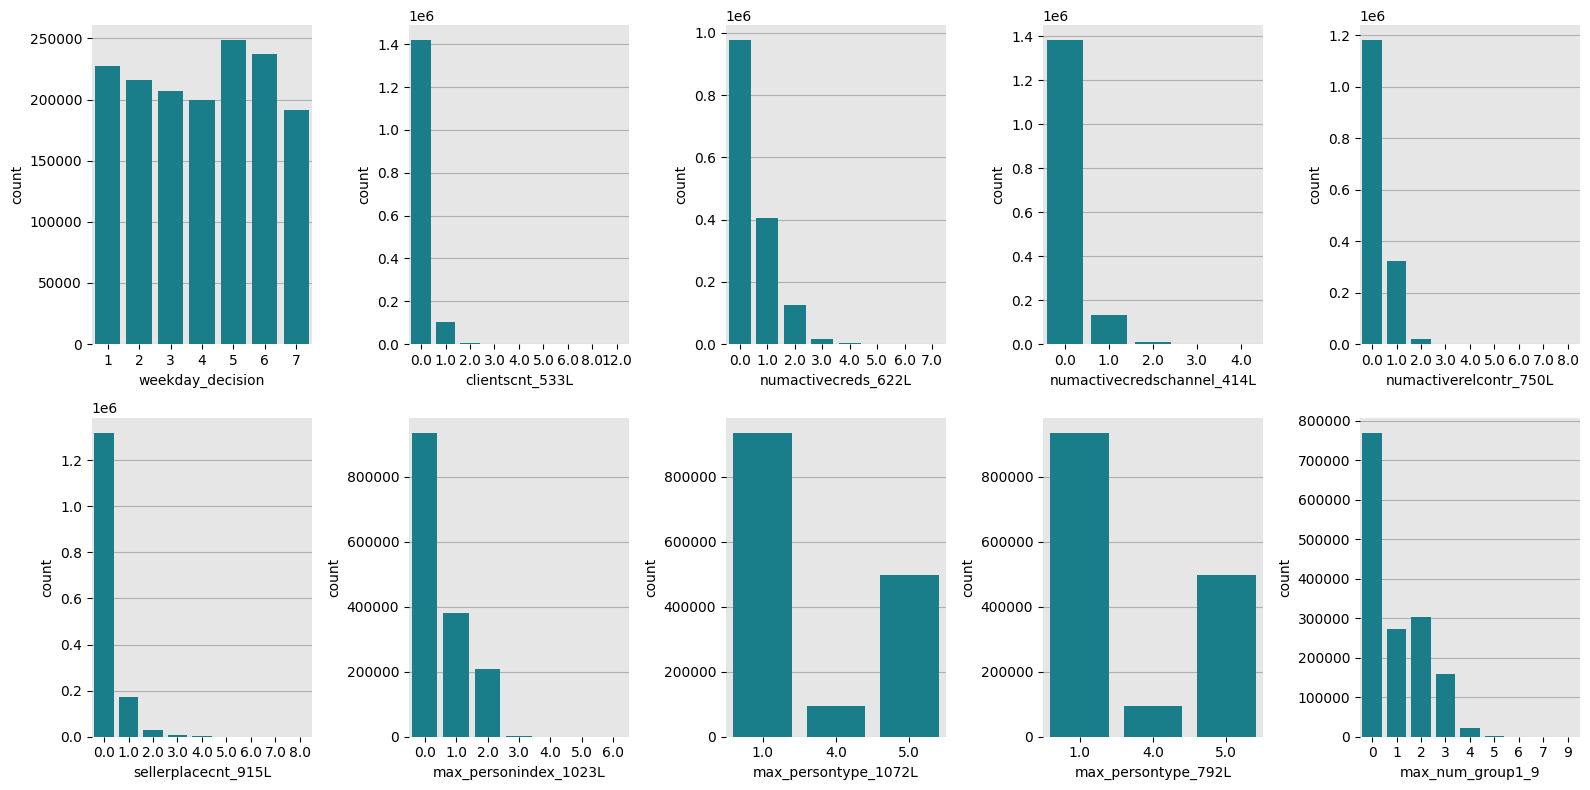

In [22]:
plot_distributions(df_train, num_cols_no_nan_low_unique_2)

In [23]:
%%time
# mannualy calculating PSI is x3 faster than using function
data = list()

# calculate weekly PSI scores
for col in num_cols_no_nan_low_unique_2:
    # all development data
    array_x = df_train.loc[:, col].values
    share_x = pd.DataFrame({"bucket": array_x}).value_counts().reset_index()
    share_x["proportion_x"] = share_x["count"] / share_x["count"].sum()
    
    # iterate over weeks
    for week in df_train["WEEK_NUM"].unique():
        array_y = df_train.loc[df_train['WEEK_NUM'] == week, col].values
        share_y = pd.DataFrame({"bucket": array_y}).value_counts().reset_index()
        share_y["proportion_y"] = share_y["count"] / share_y["count"].sum()
        
        # calculate PSI
        df_shares = share_x.merge(share_y, on="bucket", how = "outer").fillna(1e-6)
        df_shares['psi'] = (df_shares['proportion_x'] - df_shares['proportion_y']) * np.log(df_shares['proportion_x'] / df_shares['proportion_y'])
        
        data.append([col, week, df_shares['psi'].sum()])
        
df_plot = pd.DataFrame(data, columns=['Feature', "WEEK_NUM", "PSI"])

CPU times: total: 4.95 s
Wall time: 4.96 s


In [24]:
def plot_lines(df, ncols = 2):
    fig, ax = plt.subplots(int(np.ceil(df['Feature'].nunique() / ncols)), ncols, figsize=(16, df['Feature'].nunique() / ncols * 2))
    ax = ax.flatten()
    
    # iterate over columns
    for i, col in enumerate(df['Feature'].unique()):
        # count values
        _df = df[df['Feature'] == col]
        ax[i].plot(_df['WEEK_NUM'], _df['PSI'], label=col, linewidth=2.5)
        ax[i].set_xlabel("Week num.")
        ax[i].set_ylabel("PSI")
        
        # add white background to legend
        legend = ax[i].legend(frameon=1)
        frame = legend.get_frame()
        frame.set_facecolor('w')
        
        
    plt.tight_layout()

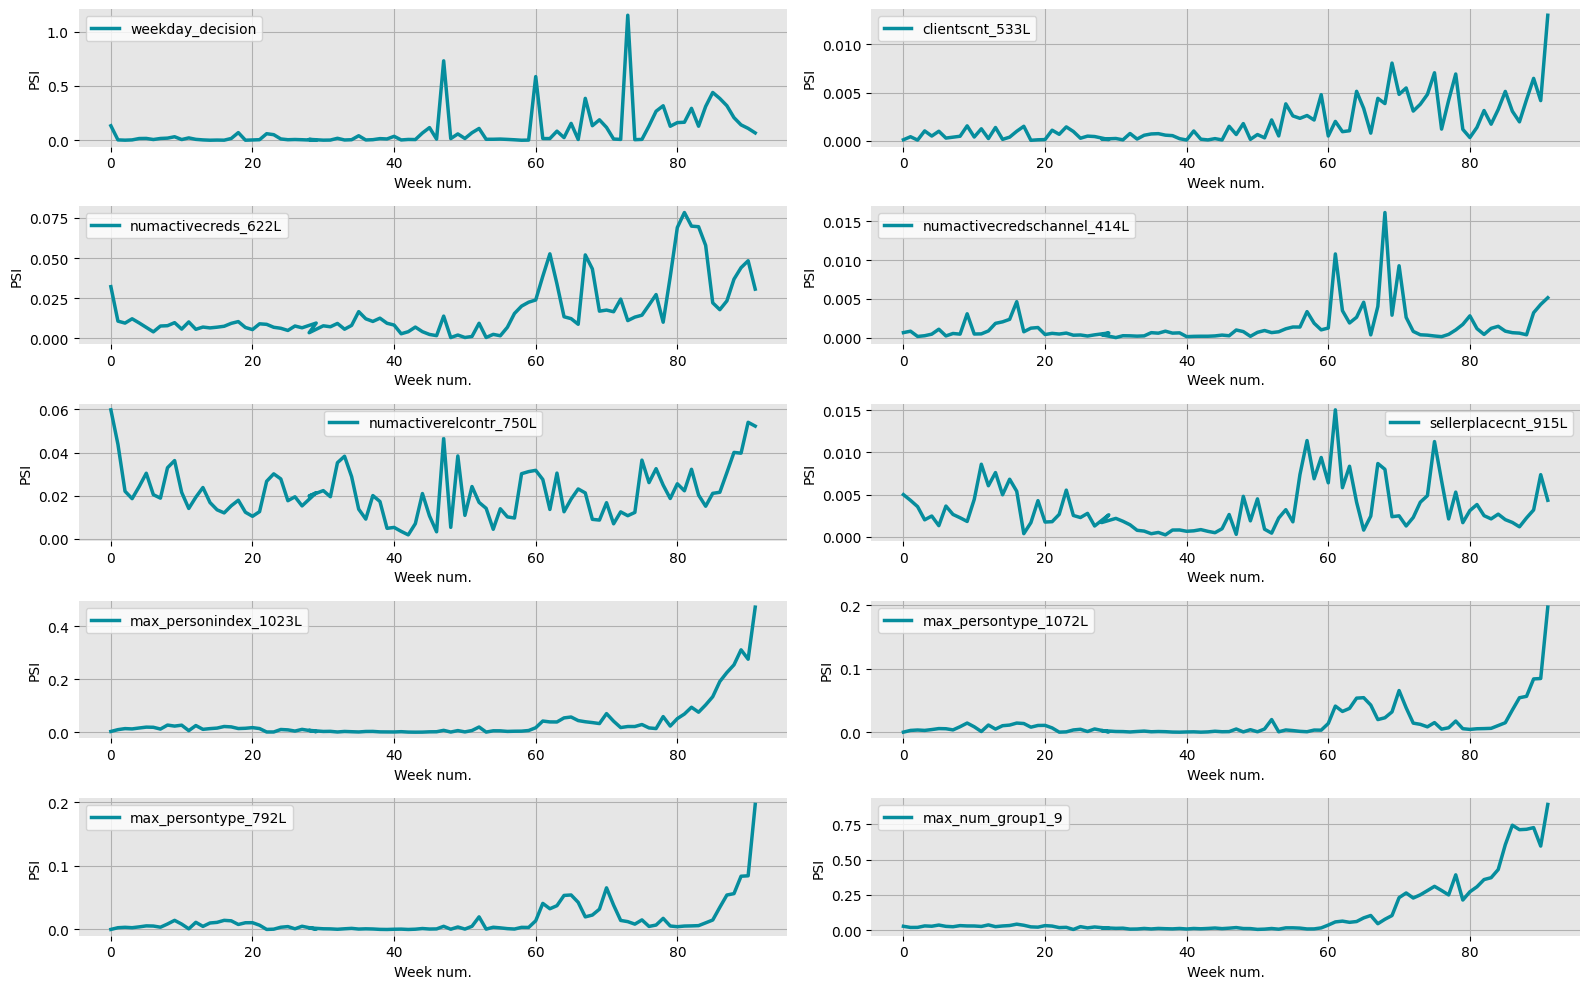

In [25]:
plot_lines(df_plot)

In [26]:
# find TOP 10 most stable, i.e. lowest weekly PSI variance, features 
_df = df_plot.groupby("Feature").agg({"PSI": ["mean", "median", "max", "min", "std"]}).round(3).sort_values(by=("PSI", "std"))
_df

PSI                            
                             mean median    max    min    std
Feature                                                      
clientscnt_533L             0.002  0.001  0.013  0.000  0.002
numactivecredschannel_414L  0.001  0.001  0.016  0.000  0.002
sellerplacecnt_915L         0.003  0.002  0.015  0.000  0.003
numactiverelcontr_750L      0.021  0.020  0.060  0.002  0.012
numactivecreds_622L         0.017  0.010  0.078  0.000  0.017
max_persontype_1072L        0.015  0.005  0.197  0.000  0.027
max_persontype_792L         0.015  0.005  0.197  0.000  0.027
max_personindex_1023L       0.038  0.014  0.473  0.000  0.075
weekday_decision            0.092  0.017  1.151  0.001  0.173
max_num_group1_9            0.122  0.027  0.892  0.005  0.202

In [27]:
# columns to select for analysis
num_cols_no_nan_high_unique = []
for _ in num_cols_no_nan:
    if 1 < df_train[_].nunique() >= 10:        
        num_cols_no_nan_high_unique.append(_)
        
# exclude month decision as there is no point in q cutting it
num_cols_no_nan_high_unique.remove('month_decision')
        
print(f"{len(num_cols_no_nan_high_unique)} numerical features were found with more than 10 unique values.")

num_cols_no_nan_high_unique_2 = []
# check whatever 1 value doesn't represent 95% of the data
for _ in num_cols_no_nan_high_unique:
    _df = df_train[_].value_counts(normalize=True)
    if _df.max() < 0.95:
        num_cols_no_nan_high_unique_2.append(_)
        
print(f"{len(num_cols_no_nan_high_unique_2)}/{len(num_cols_no_nan_high_unique)} numerical features don't have > 95% of their data in represented by one numerical value.")

30 numerical features were found with more than 10 unique values.
18/30 numerical features don't have > 95% of their data in represented by one numerical value.


In [28]:
%%time
# number of splits
N = 10

df_train_qcuts = pd.DataFrame()
df_test_qcuts = pd.DataFrame()

# create quantiles based on whole train data set
for _ in num_cols_no_nan_high_unique_2:
    ser, bins = pd.qcut(df_train[_].round(1), N, duplicates='drop', retbins=True)
    # exclude features with low number of unique quantile cuts
    if len(set(bins)) >= 10:
        df_train_qcuts[f"{_}_qcut"] = ser
        df_test_qcuts[f"{_}_qcut"] = pd.cut(df_test[_], bins=bins, include_lowest=True)
        
# col names for plotting
COLS_10_bins = df_train_qcuts.columns

CPU times: total: 1.22 s
Wall time: 1.22 s


In [29]:
# join tables
df_train = pd.concat([df_train, df_train_qcuts], axis=1)
df_test = pd.concat([df_test, df_test_qcuts], axis=1)

del df_train_qcuts, df_test_qcuts
gc.collect()

61213

C:\Users\smouz\AppData\Local\Temp\ipykernel_18988\518877851.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)
C:\Users\smouz\AppData\Local\Temp\ipykernel_18988\518877851.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)
C:\Users\smouz\AppData\Local\Temp\ipykernel_18988\518877851.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xticklabels(ax[i].get_xticklabels(), rotation=rotation)
C:\Users\smouz\AppData\Local\Temp\ipykernel_18988\518877851.py:11: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax[i].set_xtic

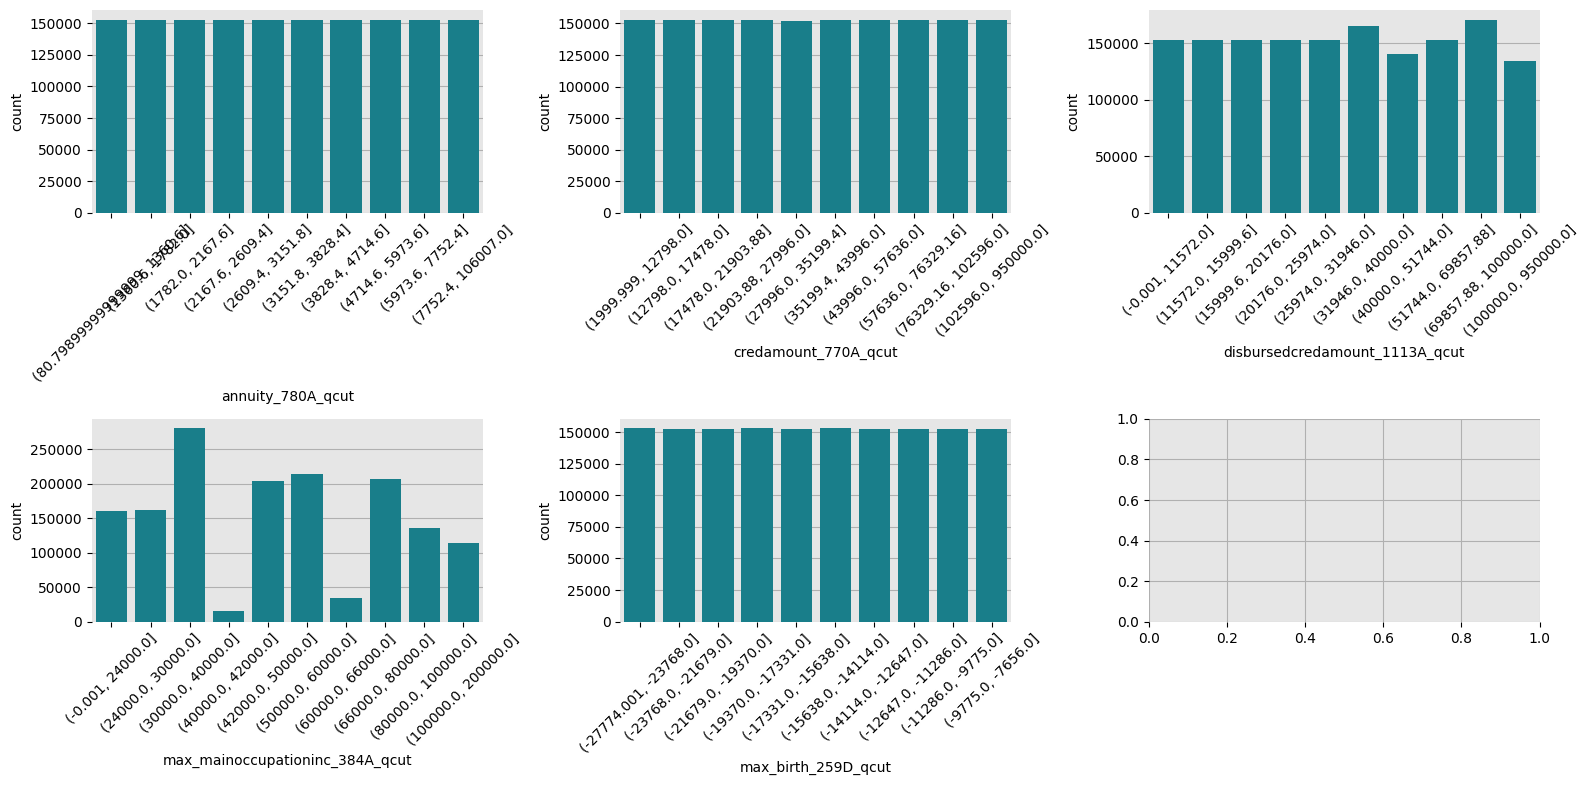

In [30]:
plot_distributions(df_train, COLS_10_bins.values.tolist(), 3, 45)

In [31]:
%%time
# mannualy calculating PSI is x3 faster than using function
data = list()

# calculate weekly PSI scores
for col in COLS_10_bins:
    # all development data
    array_x = df_train.loc[:, col].values
    share_x = pd.DataFrame({"bucket": array_x}).value_counts().reset_index()
    share_x["proportion_x"] = share_x["count"] / share_x["count"].sum()
    
    # iterate over weeks
    for week in df_train["WEEK_NUM"].unique():
        array_y = df_train.loc[df_train['WEEK_NUM'] == week, col].values
        share_y = pd.DataFrame({"bucket": array_y}).value_counts().reset_index()
        share_y["proportion_y"] = share_y["count"] / share_y["count"].sum()
        
        # calculate PSI
        df_shares = share_x.merge(share_y, on="bucket", how = "outer")
        df_shares[['proportion_x', 'proportion_y']] = df_shares[['proportion_x', 'proportion_y']].fillna(1e-6)
        df_shares['psi'] = (df_shares['proportion_x'] - df_shares['proportion_y']) * np.log(df_shares['proportion_x'] / df_shares['proportion_y'])
        
        data.append([col, week, df_shares['psi'].sum()])
        
df_plot = pd.DataFrame(data, columns=['Feature', "WEEK_NUM", "PSI"])

CPU times: total: 2.78 s
Wall time: 2.77 s


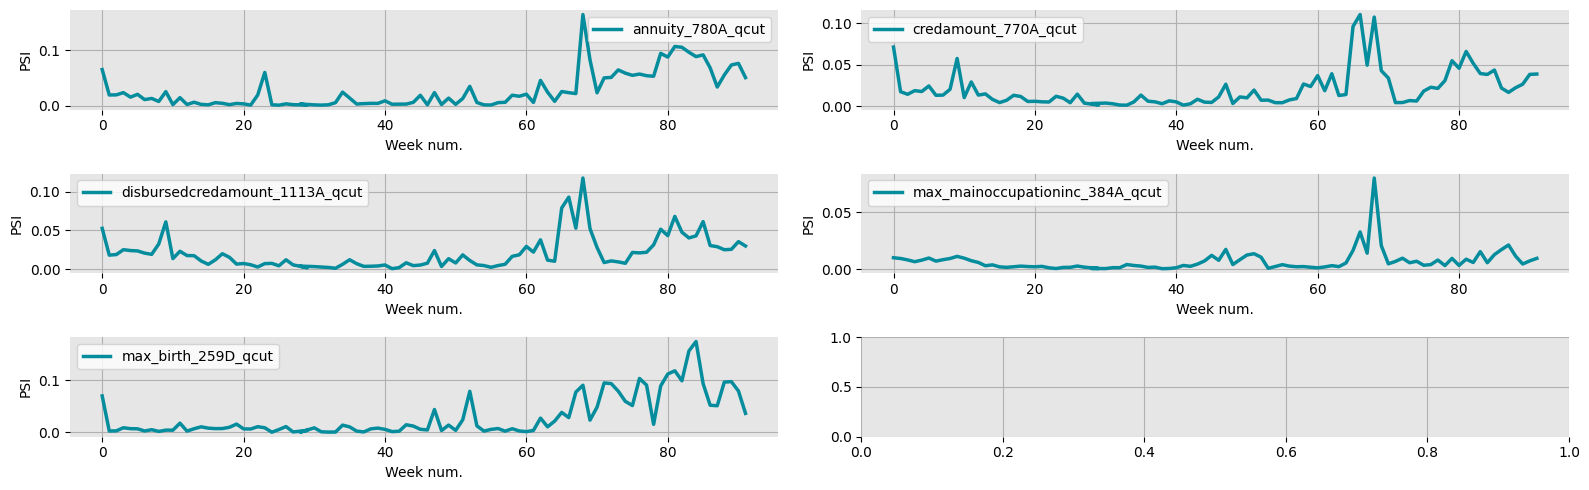

In [32]:
plot_lines(df_plot)

In [33]:
# get PSI variance stats 
_df = df_plot.groupby("Feature").agg({"PSI": ["mean", "median", "max", "min", "std"]}).round(3).sort_values(by=("PSI", "std"))
_df

PSI                            
                                  mean median    max    min    std
Feature                                                           
max_mainoccupationinc_384A_qcut  0.007  0.004  0.080  0.001  0.009
disbursedcredamount_1113A_qcut   0.021  0.014  0.117  0.001  0.021
credamount_770A_qcut             0.020  0.013  0.110  0.001  0.022
annuity_780A_qcut                0.027  0.014  0.165  0.001  0.033
max_birth_259D_qcut              0.030  0.010  0.175  0.001  0.040

## Modelling

In [34]:
%%time
# qcut columns
QCUT_COLS = ['annuity_780A_qcut', 'credamount_770A_qcut', 'disbursedcredamount_1113A_qcut', 'max_mainoccupationinc_384A_qcut', 'max_birth_259D_qcut']

# use label encoded for qcut features
# for more details refer here
# https://stackoverflow.com/questions/54507269/valueerror-circular-reference-detected-in-lightgbm
for col_name in QCUT_COLS:
    le = LabelEncoder()
    le.fit(df_train[col_name].values)
    # re-transform features
    df_train.loc[df_train[col_name].notnull(), f"{col_name}_new"] = le.transform(df_train.loc[df_train[col_name].notnull(), col_name])
    df_test.loc[df_test[col_name].notnull(),  f"{col_name}_new"] = le.transform(df_test.loc[df_test[col_name].notnull(), col_name])

CPU times: total: 26.7 s
Wall time: 26.7 s


In [35]:
TRAIN_COLS = []
# low weekly PSI numerical features with no NaN and less than 10 unique values
TRAIN_COLS += ['clientscnt_533L', 'numactivecredschannel_414L', 'sellerplacecnt_915L', 'numactiverelcontr_750L', 'numactivecreds_622L']
# remaining numerical features with no NaN and less than 10 unique values (higher PSI scores)
TRAIN_COLS += ['max_persontype_1072L', 'max_persontype_792L', 'max_personindex_1023L', 'weekday_decision', 'max_num_group1_9']
# numerical features without NaN values and large number of unique values
TRAIN_COLS += [ f"{_}_new" for _ in QCUT_COLS]

In [36]:
%%time
case_ids_train, case_ids_test = train_test_split(df_train['case_id'], train_size=0.8, random_state=SEED)

X_train = df_train.loc[df_train['case_id'].isin(case_ids_train), TRAIN_COLS + ["WEEK_NUM"]]
X_test = df_train.loc[df_train['case_id'].isin(case_ids_test), TRAIN_COLS + ["WEEK_NUM"] + ['target']]

y_train = df_train.loc[df_train['case_id'].isin(case_ids_train), 'target']
y_test = df_train.loc[df_train['case_id'].isin(case_ids_test), 'target']

print("X_train shape:", X_train.shape)

X_train shape: (1221327, 16)
CPU times: total: 391 ms
Wall time: 397 ms


In [43]:
df_train.loc[df_train['case_id'].isin(case_ids_train), TRAIN_COLS + ["WEEK_NUM"]].shape

(1221327, 16)

In [41]:
(df_train.isnull().sum() !=0).sum()

255

In [45]:
df_train.shape

(1526659, 328)

In [36]:
%%time
NO_MODELS = 3

# use week numbers for group spliting
weeks = X_train['WEEK_NUM']

cv = StratifiedGroupKFold(n_splits = NO_MODELS, shuffle=False)

ensemble_models = {}

# COMPUTE CV SCORE WITH 5 GROUP K FOLD
for i, (train_index, test_index) in enumerate(cv.split(X_train, y_train, groups=weeks)):
    print('#'*25)
    print('### Fold',i+1)
    print('#'*25)
    
    # parameters were taken from this notebook:
    # https://www.kaggle.com/code/greysky/home-credit-baseline
    lgb_params = {
        "boosting_type": "gbdt",
        'objective' : 'binary',
        'metric' : 'auc',
        "learning_rate": 0.05,
        "n_estimators": 1500,
        "colsample_bytree": 0.8, 
        "colsample_bynode": 0.8,
        "verbose": -1,
        "reg_alpha": 0.1,
        "reg_lambda": 10,
        "extra_trees":True,
        'num_leaves':64,
        "random_state": SEED + i
    }
            
    # TRAIN DATA
    train_x = X_train.iloc[train_index][TRAIN_COLS]
    train_y = y_train.iloc[train_index]

    # VALID DATA
    valid_x = X_train.iloc[test_index][TRAIN_COLS]
    valid_y = y_train.iloc[test_index]
    
    # CONVERT TO DataSet
    train_dataset = lgb.Dataset(train_x, label=train_y)
    valid_dataset = lgb.Dataset(valid_x, label=valid_y, reference=train_dataset)
    
    # TRAIN MODEL
    model = lgb.train(
        lgb_params,
        train_dataset,
        valid_sets = valid_dataset,
        callbacks = [lgb.log_evaluation(100), lgb.early_stopping(50)]
    )
    
    # VALIDATE MODELS
    preds = model.predict(valid_x, num_iteration=model.best_iteration)
    
    # SCORE ON VALID SAMPLE
    auc = roc_auc_score(valid_y, preds)
    gini = 2 * auc - 1
    print(f"\nValidation AUC: {auc:.3f}")
    print(f"Validation GINI: {gini:.3f}")

    # SAVE MODEL
    ensemble_models[f'model_{i}'] = model
        
    print()

#########################
### Fold 1
#########################


C:\Users\smouz\.conda\envs\isye6740\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.64632
[200]	valid_0's auc: 0.64989
[300]	valid_0's auc: 0.651557
[400]	valid_0's auc: 0.652418
[500]	valid_0's auc: 0.652898
[600]	valid_0's auc: 0.65327
[700]	valid_0's auc: 0.653436
Early stopping, best iteration is:
[655]	valid_0's auc: 0.653529

Validation AUC: 0.654
Validation GINI: 0.307

#########################
### Fold 2
#########################


C:\Users\smouz\.conda\envs\isye6740\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.637178
[200]	valid_0's auc: 0.640598
[300]	valid_0's auc: 0.64191
[400]	valid_0's auc: 0.642441
[500]	valid_0's auc: 0.643161
Early stopping, best iteration is:
[501]	valid_0's auc: 0.643183

Validation AUC: 0.643
Validation GINI: 0.286

#########################
### Fold 3
#########################


C:\Users\smouz\.conda\envs\isye6740\Lib\site-packages\lightgbm\engine.py:172: UserWarning: Found `n_estimators` in params. Will use it instead of argument
  _log_warning(f"Found `{alias}` in params. Will use it instead of argument")


Training until validation scores don't improve for 50 rounds
[100]	valid_0's auc: 0.643557
[200]	valid_0's auc: 0.646106
[300]	valid_0's auc: 0.646555
[400]	valid_0's auc: 0.647303
[500]	valid_0's auc: 0.647757
[600]	valid_0's auc: 0.647836
Early stopping, best iteration is:
[576]	valid_0's auc: 0.647918

Validation AUC: 0.648
Validation GINI: 0.296

CPU times: total: 18min 59s
Wall time: 1min 18s


In [37]:
%%time
df_preds = pd.DataFrame()
for i in range(NO_MODELS):
    model = ensemble_models[f'model_{i}'] 
    df_preds[f'preds_{i}'] = model.predict(X_test[TRAIN_COLS], num_iteration=model.best_iteration)
    
# add average predictions
X_test['pred'] = df_preds.mean(axis = 1).values

CPU times: total: 59.8 s
Wall time: 3.95 s


In [41]:
df_preds

,preds_0,preds_1,preds_2
0,0.044346,0.035384,0.042990
1,0.041690,0.033705,0.053610
2,0.023551,0.021864,0.022965
3,0.063003,0.043879,0.055624
4,0.028784,0.033496,0.030409
...,...,...,...
305327,0.073098,0.072465,0.066568
305328,0.020412,0.017908,0.021003
305329,0.009064,0.007586,0.009336
305330,0.035714,0.029524,0.028694


In [38]:
def validate_model(data, chart = True):
    """
    Input:
        preds, array like object
        target, array like object
        chart, boolean, if true return matplolib else table of summary statistics
    Output:
        pandas DataFrame or matplolib object
        
    Needs equal length prediction and taget column vectors
    """
    # create DataFrame for plotting and summary stats
    _df = data.copy()
    _roc = data.loc[:, ["WEEK_NUM", "target", "pred"]]\
                   .sort_values("WEEK_NUM").groupby("WEEK_NUM")[["target", "pred"]]\
                   .apply(lambda x: roc_auc_score(x["target"], x["pred"]))
    _df['ROC_AUC'] = _df['WEEK_NUM'].map(_roc)
    _df['GINI'] = 2 * _df['ROC_AUC'] - 1
    
    # stability score
    x = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['WEEK_NUM']
    y = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI']
    a, b = np.polyfit(x, y, 1)
    y_hat = a*x + b
    residuals = y - y_hat
    res_std = np.std(residuals)
    avg_gini = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI'].mean()
    w_fallingrate = 88.0
    w_resstd = -0.5 
    # calculate competition score
    score = avg_gini + w_fallingrate * min(0, a) + w_resstd * res_std
    
    if chart:
        fig, ax = plt.subplots(2, 2, figsize=(16, 10))
        
        # temporal changes of gini scores
        _df_plot = _df.groupby('WEEK_NUM')['GINI'].mean().reset_index()
        ax[0, 0].plot(_df_plot['WEEK_NUM'], _df_plot['GINI'], "o-", label = 'Weekly GINI scores')
        # add linear fit
        ax[0, 0].plot(_df_plot['WEEK_NUM'], _df_plot['WEEK_NUM'] * a + b, "r--", label = f'linear fit, k={a:.3f}')
        ax[0, 0].set_ylabel("Gini score")
        ax[0, 0].set_xlabel("Week number")
        
        # GINI score boxplot
        sns.boxplot(data=_df_plot, x="GINI", ax = ax[0, 1], color = COLORS[2])
        ax[0, 1].set_xlabel("Gini score")
        ax[0, 1].set_title(f"Q1: {np.quantile(_df_plot['GINI'].values, 0.25):.3f}, Q3: {np.quantile(_df_plot['GINI'].values, 0.75):.3f}")
        
        # GINI score histogram
        ax[1, 1].hist(_df_plot['GINI'], bins=20, label="Weekly GINI scores", color = COLORS[2])
        ax[1, 1].set_ylabel("Count")
        ax[1, 1].set_xlabel("Gini score")
        ax[1, 1].set_title(f"Mean: {_df_plot['GINI'].mean():.3f}, STD: {_df_plot['GINI'].std():.3f}")
        
        # GINI vs number of observations
        _df_plot = _df.groupby('WEEK_NUM').agg({"GINI": ['mean', "count"]})
        sns.regplot(x=_df_plot.iloc[:, 1], y=_df_plot.iloc[:, 0], ax=ax[1, 0], label=f'Corr. {_df_plot.corr().values[0, 1]:.3f}', color = COLORS[1])
        ax[1, 0].set_ylabel("Weekly Gini score")
        ax[1, 0].set_xlabel("Number of applications")
        
        # add white backgrounds to legends
        for i in range(2):
            for ii in range(2):
                legend = ax[i, ii].legend(frameon=1)
                frame = legend.get_frame()
                frame.set_facecolor('w')
        
    # return DataFrame with summary stats
    else:
        _df_stats = pd.DataFrame({"dataset": ["test"]})
        _df_stats['Avg. weekly ROC AUC'] = _df[['WEEK_NUM', 'ROC_AUC']].drop_duplicates()['ROC_AUC'].mean().round(3)
        _df_stats['Std. of weekly ROC AUC'] = _df[['WEEK_NUM', 'ROC_AUC']].drop_duplicates()['ROC_AUC'].std().round(3)
        _df_stats['Avg. weekly GINI'] = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI'].mean().round(3)
        _df_stats['Std. of weekly GINI'] = _df[['WEEK_NUM', 'GINI']].drop_duplicates()['GINI'].std().round(3)
        _df_stats['Stability score'] = round(score, 3)
        
        return _df_stats

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


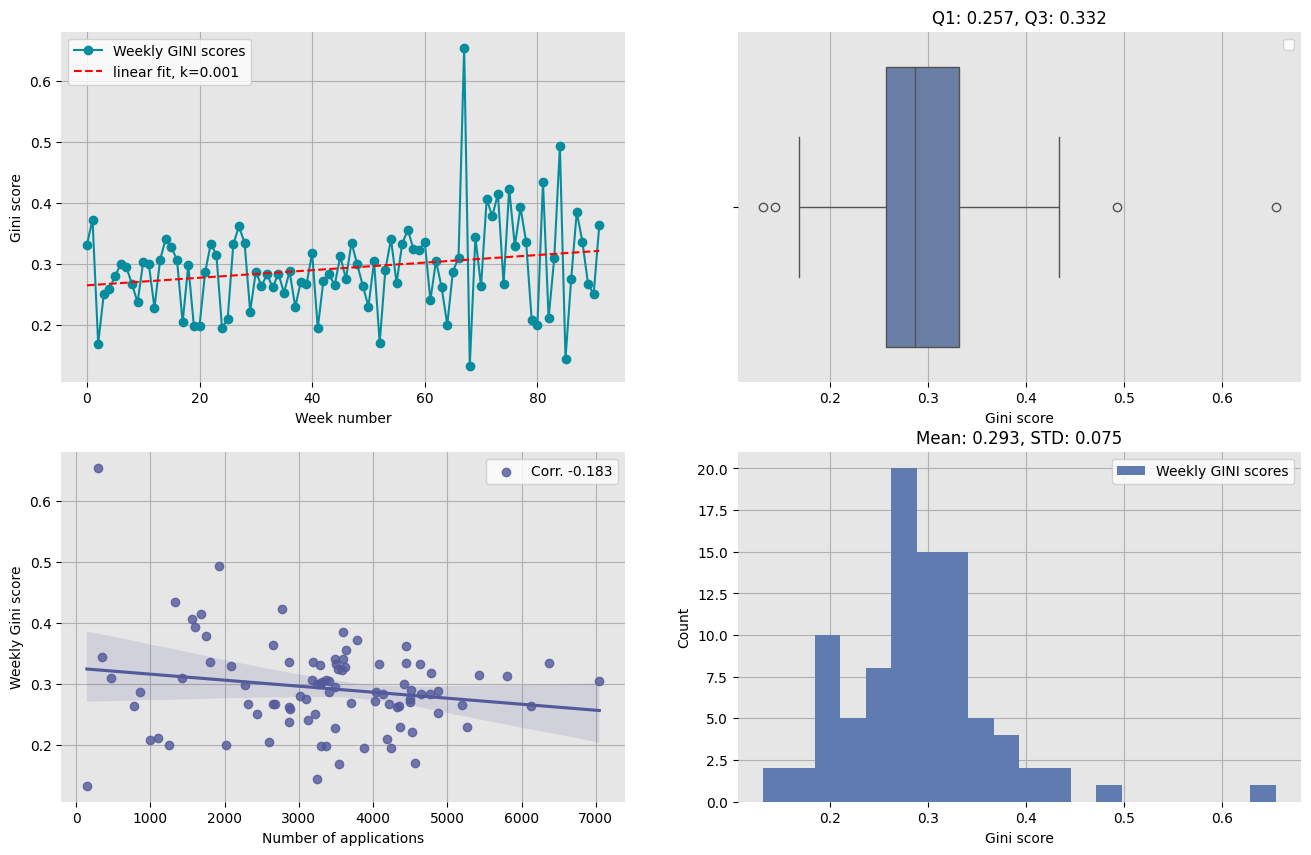

In [39]:
# make predictions on test data set
validate_model(X_test)